# Metadata

```yaml
Course:    DS 5001
Module:    12 Lab
Topic:     Classification with Naive Bayes
Author:    R.C. Alvarado
Date:      16 April 2023 (revised)
```

**Purpose:** We attempt a Naive Bayes classifier for the sentiment of a corpus of wine reviews. We use the score of the review as our sentiment value, assuming that a bad review will have negative sentiment and a good review will have positive sentiment.

# Overview

The prediction of the document's ($d$) label or class $c$ can be viewed as problem of conditional probability:
* $p(c|d)$ ?
* $p(c|d) = \large\frac{p(c)p(d|c)}{p(d)}$
* $p(c|d) = p(c)p(d|c)$

We use Maximum A Posteriori estimation (MAP) to predict the label:
* $p(c|d) = \underset{C}{\mathrm{argmax}} p(c)p(d|c)$ 

To solve this, we need to estimate the values of the priors $p(c)$ and the likelihoods $p(d|c)$.
* Prior: $p(c)$ the independent frequency of a given category.
* Likelihood: $p(d|c)$ the frequency of the document for a given category. These are essentially unigram language models for each label. They are similar to topics in this sense.

Note that $d$ is a sequence of words $w_{1}^{N}$, which means we apply the independence assumption to avoid the chain rule:
* $p(d|c) = p(w_{1}^{N}|c) = p(w_{1}|c)p(w_{2},w_{1}|c) ... $
* $p(d|c) = \prod{p(w_{i}|c}) = \sum{log(p(w_{i}|c))}$

So, we get:
* $p(c|d) = \underset{C}{\mathrm{argmax}} p(c)\sum{log(p(w_{i}|c))}$ 

We can estimate the priors and the likelihoods using Maximum Likelihood Estimation (MLE) from data that gives the joint distribution of documents and labels, where documents are represented as bags of words. This joint distribution is just the TOKEN table with the label from the LIB table joined to it.
* $(d,w,c)$


# Set Up

## Configure

In [1]:
data_in = '../data'
data_out = '../data'
prefix = 'winereviews'

**Set some parameters**

We create an empty static class to store our parameters.

In [2]:
class Params:
    qntile_P = .9
    qntile_N = .1
    n_sets = 4 # We want 4 so we can use 3 for training, 1 for testing.
    smooth_alpha = .1
    prior_method = 'docs' # 'tokens' or 'docs'    

## Import

In [3]:
import pandas as pd
import numpy as np
from numpy import log2 as log
from numpy import exp2 as exp
from numpy.random import randint
import lib.textman as tx

# Preparation

## Import wine reviews

In [4]:
docs = pd.read_csv(f'{data_in}/{prefix}/winereviews.csv', index_col='doc_id')

In [5]:
docs.head()

,doc_content,points
doc_id,,
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


## Convert points to labels

**Keep only reviews with high and low ratings**

In [6]:
bound_P = int(docs['points'].quantile(Params.qntile_P))
bound_N = int(docs['points'].quantile(Params.qntile_N))
docs = docs[(docs.points <= bound_N) | (docs.points >= bound_P)]

In [7]:
bound_N, bound_P

(84, 93)

In [8]:
docs.sample(5)

,doc_content,points
doc_id,,
124893,"Bold, ripe fruit flavors and full body give oo...",93
88048,White Merlot? Why not? It's actually a deep ro...,84
127183,Simple pear and apple work the largely nondesc...,83
125293,This impressive Brunello Riserva opens with an...,94
127166,"This tastes sweet and simple, with flavors of ...",82


**Assign labels for high and low**

In [9]:
docs.loc[docs['points'] >= 90, 'doc_label'] = 'P'
docs.loc[docs['points'] < 90, 'doc_label'] = 'N'

In [10]:
docs.head()

,doc_content,points,doc_label
doc_id,,,
336,"Gritty, heavily roasted aromas of peanuts and ...",83,N
337,"An easy and inviting selection, there's a ment...",83,N
338,The wine is earthy and somewhat rustic. There ...,82,N
339,"Red in color, with berry and apple aromas, thi...",82,N
340,"The nose is muted, despite the slight spritz o...",82,N


**Drop points columns**

In [11]:
try:
    docs = docs.drop('points', axis=1)
except KeyError as e:
    if "not found in axis" in str(e):
        pass
    else:
        print(e)

In [12]:
docs.head()

,doc_content,doc_label
doc_id,,
336,"Gritty, heavily roasted aromas of peanuts and ...",N
337,"An easy and inviting selection, there's a ment...",N
338,The wine is earthy and somewhat rustic. There ...,N
339,"Red in color, with berry and apple aromas, thi...",N
340,"The nose is muted, despite the slight spritz o...",N


## Divide docs into train and test sets

Note: Packages like SciKit learn do this for you. Here we do it from scratch.

**Assign random numbers to docs**

In [13]:
docs['set'] = randint(0, Params.n_sets, len(docs.index))

In [14]:
docs.head()

,doc_content,doc_label,set
doc_id,,,
336,"Gritty, heavily roasted aromas of peanuts and ...",N,1
337,"An easy and inviting selection, there's a ment...",N,1
338,The wine is earthy and somewhat rustic. There ...,N,3
339,"Red in color, with berry and apple aromas, thi...",N,3
340,"The nose is muted, despite the slight spritz o...",N,1


**Split docs by assigned number**

In [15]:
training_docs = docs[docs.set != 0].copy()
testing_docs = docs[docs.set == 0].copy()
del(docs)

Drop `set` columns.

In [16]:
try:
    training_docs = training_docs.drop('set', axis=1)
    testing_docs = testing_docs.drop('set', axis=1)
except KeyError as e:
    if "not found in axis" in str(e):
        pass
    else:
        print(e)

See ratio of set sizes.

In [17]:
round(len(training_docs) / len(testing_docs), 2)

2.98

## Convert docs to tokens

**Note that we only use the vocabulary of the training data.**

In [18]:
training_tokens, vocab = tx.create_tokens_and_vocab(training_docs, src_col='doc_content')
testing_tokens, _ = tx.create_tokens_and_vocab(testing_docs, src_col='doc_content')

Clean up results. Remove `term_id` from tables; just use `term_str`.\
This is only need because we are using a legacy library to do our tokenization.

In [19]:
vocab = vocab[vocab.sw == False]

In [20]:
try:
    vocab = vocab.reset_index(drop=True).set_index('term_str')
except KeyError as e:
    if "None of ['term_str'] are in the columns" in str(e):
        pass
    else:
        print(e)    

In [21]:
try:
    training_tokens = training_tokens.drop(['term_id','token'], axis=1)
    testing_tokens = testing_tokens.drop(['term_id','token'], axis=1)
except KeyError as e:
    if "not found in axis" in str(e):
        pass
    else:
        print(e)

In [22]:
training_tokens.head()

term_str
doc_id sent_id token_id         
336    0       0          gritty
               1         heavily
               2         roasted
               3          aromas
               5         peanuts

In [23]:
testing_tokens.head()

term_str
doc_id sent_id token_id          
342    0       0            funky
               1           yeasty
               2           aromas
               4         cinnamon
               5            spent

## Convert tokens to bag-of-words

In [24]:
training_bow = training_tokens.groupby(['doc_id', 'term_str']).term_str.count().to_frame('n')
testing_bow = testing_tokens.groupby(['doc_id', 'term_str']).term_str.count().to_frame('n')

In [25]:
training_bow.head()

n
doc_id term_str   
336    aromas    1
       back      1
       berry     1
       better    1
       briny     1

In [26]:
testing_bow.head()

n
doc_id term_str   
342    apple     1
       aromas    1
       bread     1
       briny     1
       cinnamon  1

## Transfer DOC labels and splits to BOW &mdash; **CRUCIAL**

We **propagate** the training doc labels to each of tokens in the docs.
Each `term_str` will then have "votes" for being either `P` or `N`.

In [27]:
try:
    training_bow = training_bow.join(training_docs[['doc_label']], on='doc_id', how='inner')
    # training_tokens = training_tokens.join(training_docs[['doc_label']], on='doc_id', how='inner')
except ValueError as e:
    if 'columns overlap' in str(e):
        pass
    else:
        print(e)

In [28]:
# training_tokens.head()

In [29]:
training_bow.head()

n doc_label
doc_id term_str             
336    aromas    1         N
       back      1         N
       berry     1         N
       better    1         N
       briny     1         N

# Training

## Estimate class priors $p(c)$

$$
\hat{P}(c) = \dfrac{N_{c}}{N_{d}}
$$

In [30]:
# training_bow.groupby('term_str')[['n']].sum().join(vocab, rsuffix='r').query("n != nr")

In [31]:
if Params.prior_method == 'tokens':
    class_priors = training_bow['doc_label'].value_counts(normalize=True)
elif Params.prior_method == 'docs':
    class_priors = training_docs['doc_label'].value_counts(normalize=True)

In [32]:
print("By", Params.prior_method)
np.round(class_priors, 3)

By docs


N    0.5
P    0.5
Name: doc_label, dtype: float64

**Convert priors to logs**

In [33]:
class_priors_log = log(class_priors)

In [34]:
class_priors_log

N   -0.999206
P   -1.000794
Name: doc_label, dtype: float64

In [35]:
# np.round(class_priors_log)

**Estimate likelihoods $p(w|c)$**

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)}{\sum_{w \in V} count(w,c)}
$$

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)+1}{\sum_{w \in V} (count(w,c)+1)} = \dfrac{count(w_i,c)+1}{(\sum_{w \in V} count(w,c))+|V|} 
$$



Now we compute the probability of a token given the label. This will in effect product two language models, one for each label. Key idea = **the likelihoods are language models** (see Pearl for interpretation of likelihoods).

In [36]:
# training_tokens

In [37]:
# class_likelihoods = training_tokens.groupby(['term_str', 'doc_label']).doc_label.count()\
#     .unstack(fill_value=0)

Note that using the bow means we do not count multiple instances of a word in a doc.

In [38]:
class_counts = training_bow.groupby(['term_str', 'doc_label']).doc_label.count()\
    .unstack(fill_value=0)

In [39]:
class_counts.head()

doc_label,N,P
term_str,,
aaron,0,4
abbey,0,3
abbott,0,3
abbreviated,3,0
ability,1,30


In [40]:
class_counts_smoothed = class_counts + Params.smooth_alpha
class_likelihoods = class_counts_smoothed  / class_counts_smoothed.sum()

In [41]:
class_likelihoods.sample(10).style.background_gradient(cmap='GnBu', axis=None)

doc_label,N,P
term_str,,
enjoyable,0.000147,0.000196
essential,0.000001,0.000019
intriguingly,0.000007,0.000037
pudding,0.000013,0.000019
urban,0.000013,0.000008
standing,0.000013,0.000023
demonstrates,0.000001,0.000023
satisfaction,0.000007,0.000011
fresh,0.004197,0.003310


## Convert likelihoods to logs

In [42]:
class_likelihoods_log = log(class_likelihoods)

In [43]:
class_likelihoods_log.sample(10).style.background_gradient(cmap='GnBu')

doc_label,N,P
term_str,,
grillo,-15.291581,-21.366933
toughness,-15.694937,-15.694507
veneer,-15.694937,-15.027083
undrinkable,-15.694937,-15.027083
volcanic,-17.189702,-14.036016
catty,-15.694937,-21.366933
feral,-13.990922,-13.086162
wonder,-15.291581,-15.027083
newer,-17.189702,-15.436195


# Testing

## Add likelihood columns to test tokens table

This is effectively how we apply our model to the test set.

In [44]:
testing_tokens.head()

term_str
doc_id sent_id token_id          
342    0       0            funky
               1           yeasty
               2           aromas
               4         cinnamon
               5            spent

In [45]:
try:
    testing_tokens = testing_tokens\
        .join(class_likelihoods_log[['P','N']], on='term_str', how='inner')
except ValueError as e:
    if "columns overlap" in str(e):
        pass
    else:
        print(e)

In [46]:
testing_tokens.sample(5)

,,,term_str,P,N
doc_id,sent_id,token_id,,,
126957,0,1,dry,-8.095032,-7.040532
95531,0,27,leather,-8.823176,-9.986465
75951,1,7,concentrated,-7.996381,-11.966139
9795,0,19,texture,-7.923341,-8.321300
38716,1,2,tastes,-11.385365,-7.888206


## Compute posteriors $p(c|w)$

$$
c_{NB} = \arg\max \log{P(c)} + \sum_{id=1}^{id_{max}} \log{P(token_{id}|c)}
$$




In [47]:
# testing_docs['prediction'] = testing_tokens.groupby('doc_id')\
#     .apply(lambda x: x[['P','N']].sum())\
#     .apply(lambda x: x + class_priors_log, axis=1)\
#     .idxmax(1)

In [48]:
testing_docs['prediction'] = testing_tokens.groupby('doc_id')\
    .apply(lambda x: x[['P','N']].sum() + class_priors_log).idxmax(1)

In [49]:
testing_docs.sample(10)

,doc_content,doc_label,prediction
doc_id,,,
52795,"From Passadouro's old vines, this is serious, ...",P,P
111251,Juicy red fruits are the veneer on a wine that...,P,P
74337,"Light lemon and melon aromas lead the nose, bu...",N,N
107056,Candied blueberry and syrupy aromas jump from ...,N,N
7088,"Smells raisiny-Porty, and turns dry and auster...",N,N
7084,"This is light and seems a little sparkly, as i...",N,N
127157,"Green, unripe vegetal notes se compromise this...",N,N
23981,This was the final vintage Patrick Campbell fu...,P,P
37365,"Robust and full-bodied, as you'd expect from t...",P,P


# Evaluation

In [50]:
testing_docs['result'] = testing_docs.doc_label == testing_docs.prediction
testing_docs['result_label'] = testing_docs.apply(lambda x: str(x.result)[0] + x.prediction, 1)

In [51]:
testing_docs.sample(10)

,doc_content,doc_label,prediction,result,result_label
doc_id,,,,,
88053,A light Chardonnnay showing pineapple and pea...,N,N,True,TN
118062,The 2008 vintage presented challenges for Cabe...,P,P,True,TP
25954,"Opening with a rich, luxurious nose, this wine...",P,P,True,TP
47520,This TBA features almost endless variations on...,P,P,True,TP
15208,A wine made like this doesn't come along every...,P,P,True,TP
6931,Hints of bramble and mint meld into fresh blac...,P,P,True,TP
127369,This is a devastatingly good Bordeaux blend fr...,P,P,True,TP
34327,"A pale copper-pink color, this rosé is light a...",N,N,True,TN
31409,There's a pinpoint-like delicacy to this dazzl...,P,P,True,TP


## Show raw T & F counts

In [52]:
raw = testing_docs.result.value_counts()

In [53]:
raw

True     5896
False     206
Name: result, dtype: int64

In [54]:
raw[True] / raw[False]

28.62135922330097

## Show raw TP, TN, FP, FN counts

In [55]:
raw1 = testing_docs.result_label.value_counts()

In [56]:
raw1

TP    3048
TN    2848
FP     149
FN      57
Name: result_label, dtype: int64

In [57]:
# Accuracy
(raw1.TP + raw1.TN) / raw1.sum()

0.9662405768600459

## Create confusion matrix

In [58]:
CM = testing_docs.reset_index().groupby(['prediction','doc_label']).doc_id.count().unstack().fillna(0)

In [59]:
CM.columns.name = 'actual'

In [60]:
CM.style.background_gradient(axis=None)

actual,N,P
prediction,,
N,2848,57
P,149,3048


In [80]:
def get_results(CM):

    class Results():
        
        TP = CM.iloc[0,0] # hits
        FP = CM.iloc[0,1] # Type I errors; false alarms
        TN = CM.iloc[1,1] # correct rejections
        FN = CM.iloc[1,0] # Type  II errors; misses
        
        T = TP + TN
        F = FP + FN
        ALL =  T + F
        
        ACC = T / ALL                       # Accuracy
        TPR = TP / (TP + FN)                # Recall, Sensitivity
        TNR = TN / (TN + FP)                # Specificity
        PPV = TP / (TP + FP)                # Precision; Positive predictive value 
        BA = (TNR + TPR) / 2                # Balanced Accuracy
        F1 = (2 *  TP) / (2 * TP + FP + FN) # F-score where F =  1

        assert ALL == CM.sum().sum()
                
        def show_results(self):
            print('TPR:', round(self.TPR, 2), '(sensitivity)')
            print('TNR:', round(self.TNR, 2), '(specificity)')
            print('F1: ', round(self.F1, 2), '<-- GRADE')
            print('-'*9)
            print('PPV:', round(self.PPV, 2),  '(precision)')
            print('ACC:', round(self.ACC, 2), '(accuracy)')
            
    return Results()

In [81]:
R = get_results(CM)

In [83]:
R.show_results()

TPR: 0.95 (sensitivity)
TNR: 0.98 (specificity)
F1:  0.97 <-- GRADE
---------
PPV: 0.98 (precision)
ACC: 0.97 (accuracy)


# Exploration

## Likelihoods as Sentiment Lexicon 

We make up a way to compute sentiment valence and polarity

In [84]:
sentilex = (class_likelihoods_log.P - class_likelihoods_log.N).to_frame('valence')

In [85]:
sentilex['polarity'] = np.sign(sentilex['valence'])

**Ratio of positive to negative terms**

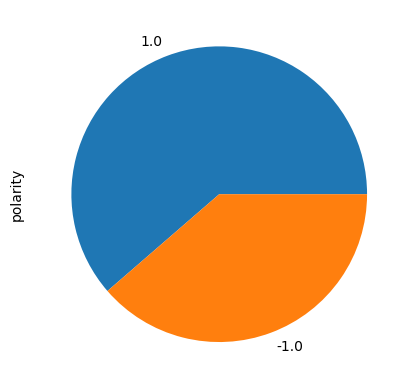

In [86]:
sentilex.polarity.value_counts().plot(kind='pie');

## Top positive words

In [87]:
sentilex.sort_values('valence', ascending=False).head(10)

,valence,polarity
term_str,,
superb,9.487994,1.0
pipe,9.360352,1.0
exceptional,9.205528,1.0
dramatic,8.776056,1.0
seamless,8.735471,1.0
premier,8.693712,1.0
parcel,8.693712,1.0
sites,8.650707,1.0
sagebrush,8.537229,1.0


## Top negative words

In [88]:
sentilex.sort_values('valence', ascending=True).head(10)

,valence,polarity
term_str,,
everyday,-11.362557,-1.0
bland,-11.085214,-1.0
watery,-10.971647,-1.0
mealy,-10.611101,-1.0
dilute,-10.564857,-1.0
weedy,-10.564857,-1.0
pickled,-10.533183,-1.0
strange,-10.308386,-1.0
melony,-9.949020,-1.0


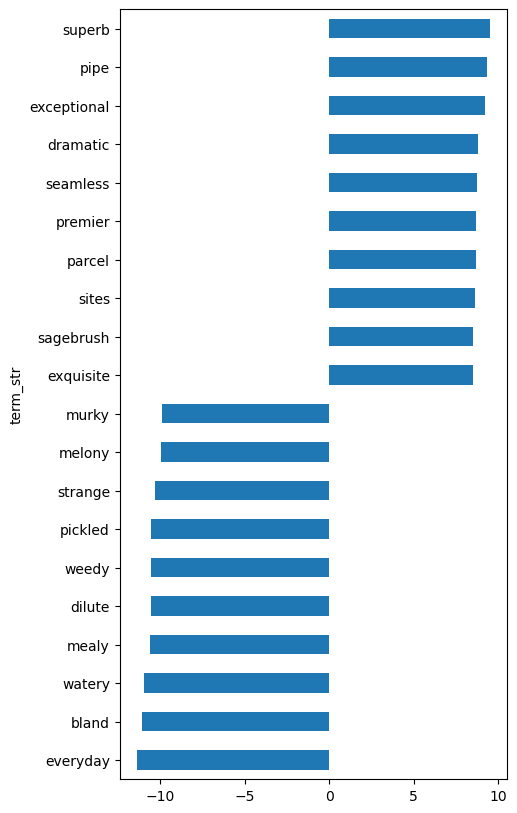

In [69]:
wpos = sentilex.valence.sort_values().tail(10)
wneg = sentilex.valence.sort_values().head(10)
pd.concat([wneg,wpos]).plot.barh(figsize=(5,10));

# Save

In [70]:
sentilex .to_csv(f"{data_out}/{prefix}/{prefix}-NB_SALEX.csv", index=True)
training_docs.to_csv(f"{data_out}/{prefix}/{prefix}-DOCS_training.csv", index=True)
testing_docs.to_csv(f"{data_out}/{prefix}/{prefix}-DOCS_testing.csv", index=True)
training_bow.to_csv(f"{data_out}/{prefix}/{prefix}-BOW_training.csv", index=True)
testing_bow.to_csv(f"{data_out}/{prefix}/{prefix}-BOW_testing.csv", index=True)
vocab.to_csv(f"{data_out}/{prefix}/{prefix}-VOCAB.csv", index=True)